In [1]:
import cv2
import numpy as np
from utils import imshow
import matplotlib.pyplot as plt

In [2]:
class MotionHistogram:
    
    def __init__(self):
        self.fig = plt.figure()
        self.c = 0
        self.bins = np.arange(-10,10,0.3)
        
    def draw(self, p1, p0):
        if self.c < 10:
            self.c += 1
            return
        plt.clf()
        self.c = 0
        t = p1 - p0
        t = t.flatten()
        x_mot = t[0::2]
        y_mot = t[1::2]

        plt.hist(x_mot, bins=self.bins, label='x', color='orange', alpha=0.5)
#         plt.hist(y_mot, bins=self.bins, label='y', color='blue', alpha=0.5)
        # redraw the canvas
        self.fig.canvas.draw()

        # convert canvas to image
        img = np.fromstring(self.fig.canvas.tostring_rgb(), dtype=np.uint8,
                sep='')
        img  = img.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))

        # img is rgb, convert to opencv's default bgr
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

        cv2.imshow('hist',img)
        
    def mode(self, p1, p0):
        t = p1 - p0
        t = t.flatten()
        x_mot = t[0::2]
        y_mot = t[1::2]
        uniq, count = np.unique(x_mot, return_counts=True)
        mode_x = uniq[np.argmax(count)]
        uniq, count = np.unique(y_mot, return_counts=True)
        mode_y = uniq[np.argmax(count)]
        
#         return mode_x, mode_y
        return np.median(x_mot), np.median(y_mot)
    


In [3]:
class TemplateTracker:
    """ Generates template from starting coordinates and tracks in video"""
    TEMPLATE_WIDTH = 50
    TEMPLATE_HIGHT = 50
    SEARCH_DELTA = 100
    
    def __init__(self, frame, x_0, y_0):
        self.x = x_0
        self.y = y_0
        self._generate_template(frame, x_0, y_0)
        
    def _generate_template(self, frame, x, y):
        'create template from frame with center at x,y'
#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        dx = self.TEMPLATE_WIDTH / 2
        dy = self.TEMPLATE_HIGHT / 2
        self.template = frame[y-dy:y+dy, x-dx:x+dx]
    
    
    def track_new_loc(self, frame):
        min_row = max(0, int(self.y)-self.SEARCH_DELTA)
        max_row = min(int(self.y)+self.SEARCH_DELTA, frame.shape[0] - 1)
        min_col = max(0, int(self.x)-self.SEARCH_DELTA)
        max_col = min(int(self.x)+self.SEARCH_DELTA, frame.shape[1] - 1)
#         print min_row, max_row, min_col, max_col
        sub_frame = frame[min_row:max_row,
                          min_col:max_col]
        assert sub_frame.shape[0] >= self.template.shape[0], str(sub_frame.shape)+" "+str(self.template.shape)
        assert sub_frame.shape[1] >= self.template.shape[1]
        res = cv2.matchTemplate(sub_frame, self.template, 5) # using SQDIFF_NORMED
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        top_left = list(max_loc)
        if max_val > 0.8:
#         cv2.circle(sub_frame, tuple(top_left), 10, (0,0,0), -1)
#         bottom_right = tuple([top_left[0]+self.TEMPLATE_WIDTH, top_left[1]+self.TEMPLATE_HIGHT])
#         cv2.rectangle(sub_frame, tuple(top_left), bottom_right, 255, 2)
#         imshow("sub_frame", sub_frame)
#         imshow("conv", res, gray=True)
            self.x = top_left[0] + min_col + self.TEMPLATE_WIDTH / 2
            self.y = top_left[1] + min_row + self.TEMPLATE_HIGHT / 2
        
    def apply_motion(self, dx, dy):
        self.x += dx
        self.y += dy
    
    def draw_rect(self, frame):
        top_left = (int(self.x) - self.TEMPLATE_WIDTH/2, int(self.y) - self.TEMPLATE_HIGHT/2)
        bottom_right = (int(self.x) + self.TEMPLATE_WIDTH/2, int(self.y) + self.TEMPLATE_HIGHT/2)
        cv2.rectangle(frame, top_left, bottom_right, 255, 2)
    
    def show_template(self):
        imshow("template", self.template)

In [4]:
cap =cv2.VideoCapture("../lecture.mp4")

for _ in range(120):
    a,b = cap.read()

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.6,
                       minDistance = 20,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()


corner_mask = np.zeros(old_frame.shape[:2], dtype='uint8')
corner_mask[:150,:] = 255
# imshow("mask",corner_mask, gray=True)

old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = corner_mask, **feature_params)

frame_cpy = old_frame.copy()
corners = np.array([[285,70],[1170,50],[300,420],[1160,400]], dtype='float64')
for i in range(corners.shape[0]):
    t_x, t_y = corners[i]
    if 0 < t_x < old_frame.shape[1] and 0 < t_y < old_frame.shape[0]:
        cv2.circle(frame_cpy, (int(t_x),int(t_y)), 10, (0,0,0), -1)
# imshow("first", frame_cpy)

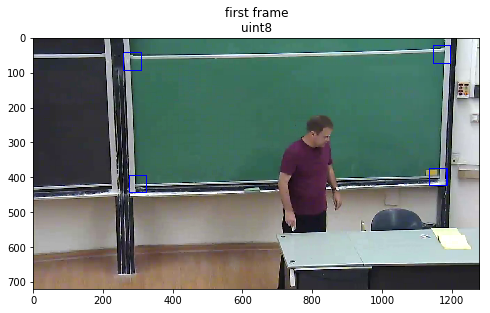

In [5]:
# setting tracker templates
corner_templates2 = []
frame_cpy = old_frame.copy()
for c in np.uint16(corners):
    corner_templates2.append(TemplateTracker(old_frame, c[0], c[1]))
    corner_templates2[-1].draw_rect(frame_cpy)
imshow('first frame', frame_cpy)

In [6]:
bg = None
counter = 0
moving = False
def rectify(frame):
    global bg
    global counter
    global moving
    x0 = frame.shape[1]
    y0 = frame.shape[0]
    big = np.zeros(tuple([i * 3 for i in frame.shape[:2]]+[frame.shape[2]]), dtype='uint8')
    big[y0:y0+frame.shape[0],x0:x0+frame.shape[1]] = frame
    pts1 = np.float32([[x0+t.x, y0+t.y] for t in corner_templates2])
    pts2 = np.float32([[0,0],[750,0],[0,300],[750,300]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(big,M,(750,300))
    if bg is None:
        bg = dst
    elif counter % 25 == 0:
        bg[dst!=0] = dst[dst!=0]
    dst[dst==0] = bg[dst==0]
    counter+=1
    
#     small = cv2.resize(big, (0,0), fx=0.5, fy=0.5) 
#     imshow('small', big)
    cv2.imshow("big", dst)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


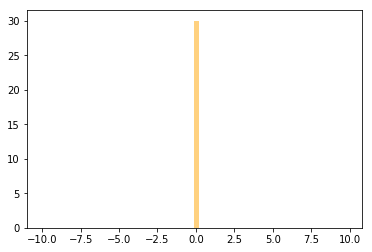

In [7]:

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
motion_hist = MotionHistogram()


while(1):
    ret, frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    if p1 is None:
        break
        
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    
    motion_hist.draw(good_new, good_old)

    mode_x, mode_y = motion_hist.mode(good_new, good_old)
    moving = abs(mode_x) > 3
    for t in corner_templates2:
        t.apply_motion(mode_x, mode_y)
        if 0 < t.x < frame.shape[1] and 0 < t.y < frame.shape[0]:
            t.track_new_loc(frame)
            t.draw_rect(frame)
        
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
        

#     corners += [mode_x, mode_y]
#     for i in range(corners.shape[0]):
#         t_x, t_y = corners[i]
#         if 0 < t_x < frame.shape[1] and 0 < t_y < frame.shape[0]:
#             frame = cv2.circle(frame, (int(t_x),int(t_y)), 10, (0,0,0), -1)
    img = cv2.add(frame,mask)
    mask = np.uint8(mask*0.9)
    
    rectify(frame)

    cv2.imshow('frame',img)
    k = cv2.waitKey(1) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
    if p0.shape[0] < 30:
        p0 = np.vstack((p0, cv2.goodFeaturesToTrack(old_gray, mask = corner_mask, **feature_params)))

cv2.destroyAllWindows()
cap.release()